# Model Selection & Evaluation

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load Dataset

In [3]:
data = pd.read_csv('credit_risk_dataset.csv')

In [4]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
data.shape

(32581, 12)

In [6]:
data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [7]:
y = data['loan_status'].copy()
X = data.drop(columns='loan_status').copy()

In [8]:
num_columns = X.select_dtypes(include='number').columns.tolist()
cat_columns = X.select_dtypes(include='object').columns.tolist()

print("Total numerical columns :", len(num_columns))
print("Total categorical columns :", len(cat_columns))

Total numerical columns : 7
Total categorical columns : 4


In [9]:
num_idx = [X.columns.get_loc(c) for c in num_columns]
cat_idx = [X.columns.get_loc(c) for c in cat_columns]

In [10]:
X.columns[num_idx]

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

In [11]:
X.columns[cat_idx]

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

### Simple Statistics

In [12]:
X.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [13]:
X.describe(include='object').T

,count,unique,top,freq
person_home_ownership,32581,4,RENT,16446
loan_intent,32581,6,EDUCATION,6453
loan_grade,32581,7,A,10777
cb_person_default_on_file,32581,2,N,26836


### Check missing value

In [14]:
X.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

### Fill Missing Values

The missing value in the feature **loan interest rate** is filled in using the mean of each grade in the feature **loan grade**, because the better the loan grade value (A > B > C > D > E > F > G) the smaller the interest rate will be. It can be seen in the pivot table below:

In [15]:
# Create pivot table feature loan_grade with mean loan_int_rate
table = pd.pivot_table(X, index=['loan_grade'], values=['loan_int_rate'], aggfunc='mean')
table['loan_int_rate'] = table['loan_int_rate'].round(decimals=2)
table

,loan_int_rate
loan_grade,
A,7.33
B,11.00
C,13.46
D,15.36
E,17.01
F,18.61
G,20.25


In [16]:
# Fill missing value from 'loan_intention_rate' feature
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'A', X['loan_int_rate'].fillna(7.33))
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'B', X['loan_int_rate'].fillna(11.00))
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'C', X['loan_int_rate'].fillna(13.46))
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'D', X['loan_int_rate'].fillna(15.36))
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'E', X['loan_int_rate'].fillna(17.01))
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'F', X['loan_int_rate'].fillna(18.26))
X['loan_int_rate'] = X['loan_int_rate'].mask(X['loan_grade'] == 'G', X['loan_int_rate'].fillna(20.25))

In [17]:
# Fill missing value from 'person_emp_length' feature
X['person_emp_length'] = X['person_emp_length'].fillna(X['person_emp_length'].median())

## Correlated Features

In [18]:
def plot_correlation(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig = plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap='coolwarm',
        square=True,
        linewidths=0.3,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8},
        cbar_kws={"shrink": .5}
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    ax.set_title("Correlation", size=14)

    plt.show()

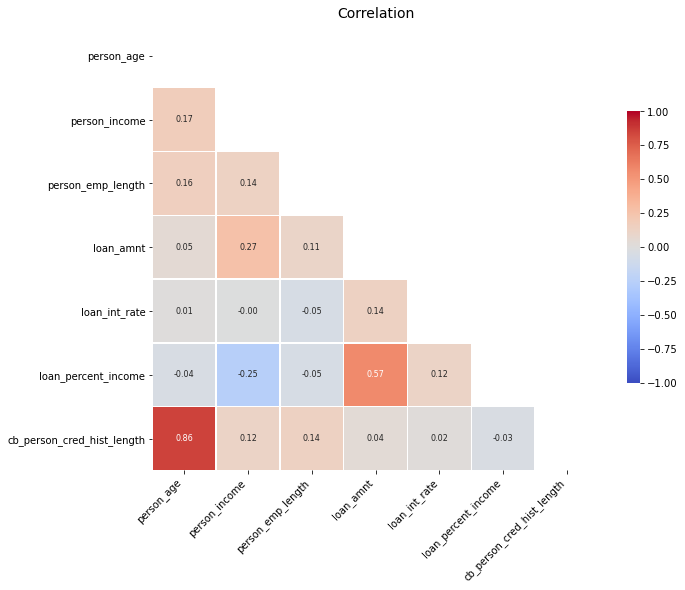

In [19]:
plot_correlation(X[num_columns])

## Data Splitting

In [20]:
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print("Number of Train :", len(y_train), f"{round(len(y_train) / len(y) * 100, 2)}%")
print("Number of Test :", len(y_test), f"{round(len(y_test) / len(y) * 100, 2)}%")

Number of Train : 22806 70.0%
Number of Test : 9775 30.0%


In [21]:
print("Percentage of target in Train :", np.mean(y_train))
print("Percentage of target in Test :", np.mean(y_test))

Percentage of target in Train : 0.216872752784355
Percentage of target in Test : 0.2211764705882353


In [ ]:
# Save to csv

# X_train.to_csv('X_train.csv')
# y_train.to_csv('y_train.csv')
# X_test.to_csv('X_test.csv')
# y_test.to_csv('y_test.csv')

In [22]:
# X_train.sample(1).to_dict(orient='records')

[{'person_age': 29,
  'person_income': 120000,
  'person_home_ownership': 'MORTGAGE',
  'person_emp_length': 7.0,
  'loan_intent': 'DEBTCONSOLIDATION',
  'loan_grade': 'B',
  'loan_amnt': 20000,
  'loan_int_rate': 12.42,
  'loan_percent_income': 0.17,
  'cb_person_default_on_file': 'N',
  'cb_person_cred_hist_length': 6}]

### Data Preprocess

Distinguish numerical and categorical variable since it will have a different approach of preprocessing

In [23]:
def get_data_by_types(X_train, X_test):
    X_train_num, X_train_cat = X_train[num_columns], X_train[cat_columns]
    X_test_num, X_test_cat = X_test[num_columns], X_test[cat_columns]
    return X_train_num, X_train_cat, X_test_num, X_test_cat

In [24]:
X_train_num, X_train_cat, X_test_num, X_test_cat = get_data_by_types(X_train, X_test)

#### Categorical Variable

Because most of the features are categorical, therefore the categorical features must first be converted to numerical so that they can be processed by machine learning.

In [25]:
ohe = OneHotEncoder()
ohe.fit(X_train_cat)

X_train_cat = ohe.transform(X_train_cat).toarray()
X_test_cat = ohe.transform(X_test_cat).toarray()

In [26]:
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names(cat_columns), index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names(cat_columns), index=X_test.index)

#### Numerical Variable

In [ ]:
# sc = StandardScaler()
# sc.fit(X_train.loc[:, num_columns])

In [ ]:
# X_train_num = sc.transform(X_train[num_columns])
# X_test_num = sc.transform(X_test[num_columns])

In [ ]:
# X_train_num = pd.DataFrame(X_train_num, columns=num_columns)
# X_test_num = pd.DataFrame(X_test_num, columns=num_columns)

In [27]:
X_train_trans = X_train_num.join(X_train_cat)
X_test_trans = X_test_num.join(X_test_cat)

In [28]:
X_train_trans.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
12657,25,66300,9.0,1700,6.76,0.02,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11611,22,75000,6.0,25000,9.25,0.33,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18223,31,105400,2.0,24250,15.31,0.20,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
24772,35,75000,5.0,5000,8.70,0.07,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30770,36,65000,6.0,23325,15.27,0.36,14,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


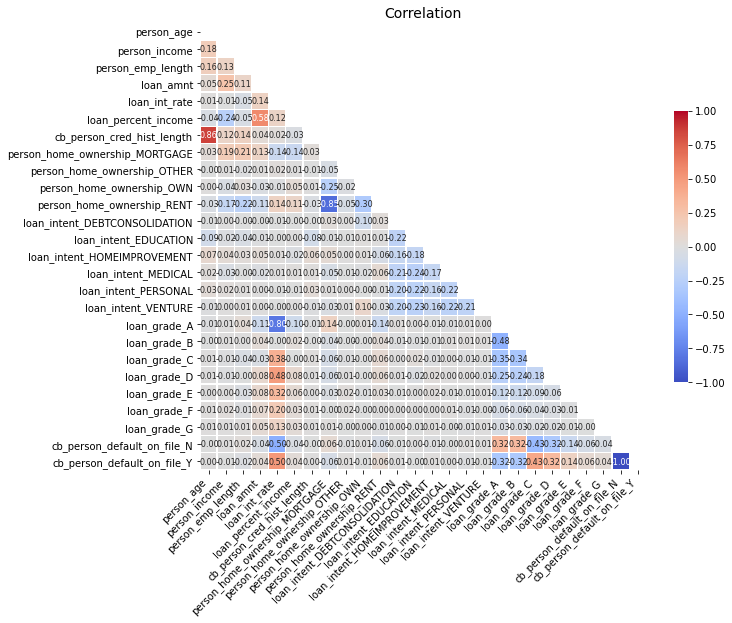

In [29]:
plot_correlation(X_train_trans)

### Train Model

In [32]:
lr = LogisticRegression(random_state=SEED, max_iter=1000)
lr.fit(X_train_trans, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [35]:
yhat_train = lr.predict_proba(X_train_trans)[:, 1]
yhat_test = lr.predict_proba(X_test_trans)[:, 1]

# Base model

In [36]:
print("ROC-AUC Score Train:", roc_auc_score(y_train, yhat_train))
print("ROC-AUC Score Test:", roc_auc_score(y_test, yhat_test))

ROC-AUC Score Train: 0.7619865204907287
ROC-AUC Score Test: 0.7601628525528354


In [37]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def get_optimal_cutoff(tpr, fpr, thresholds):
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({
        'fpr' : pd.Series(fpr, index=i),
        'tpr' : pd.Series(tpr, index = i), 
        '1-fpr' : pd.Series(1-fpr, index = i), 
        'tf' : pd.Series(tpr - (1-fpr), index = i), 
        'thresholds' : pd.Series(thresholds, index = i)})
    
    print(roc.iloc[[(roc.tf-0).abs().argmin()]])

    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    _ = plt.plot(roc['tpr'])
    _ = plt.plot(roc['1-fpr'], color = 'red')
    _ = plt.xlabel('1-False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic')
    _ = ax.set_xticklabels([])
    
    
def plot_roc_auc(tpr, fpr, labels):
    
    if (isinstance(tpr, (list, np.array)) and isinstance(fpr, (list, np.array))):
        
        nlist = len(tpr)
        
        if all(len(val) == nlist for val in [tpr, fpr, labels]):
            pass
        else:
            raise ValueError('length of parameter should be the same')
               
        fig, ax = plt.subplots(figsize=(8, 6.5))
        _ = sns.despine(ax=ax)
        _ = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
        _ = ax.set_xlim([0.0, 1.0])
        _ = ax.set_ylim([0.0, 1.05])
        _ = ax.set_xlabel('False Positive Rate')
        _ = ax.set_ylabel('True Positive Rate')
        _ = ax.set_title('Receiver operating characteristic example')
        
        for i in range(nlist):
        
            roc_auc = auc(fpr[i], tpr[i])
            _ = ax.plot(
                fpr[i], 
                tpr[i], 
                label=f'ROC curve {labels[i]} (area = {roc_auc: 0.2f}'
            )
        
        _ = fig.legend(loc="right")
        
    else:
        roc_auc = auc(fpr, tpr)
        
        fig, ax = plt.subplots(figsize=(8, 6.5))
        _ = sns.despine(ax=ax)
        _ = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
        _ = ax.set_xlim([0.0, 1.0])
        _ = ax.set_ylim([0.0, 1.05])
        _ = ax.set_xlabel('False Positive Rate')
        _ = ax.set_ylabel('True Positive Rate')
        _ = ax.set_title('Receiver operating characteristic example')
        _ = ax.plot(
            fpr, 
            tpr, 
            label=f'ROC curve {labels} (area = {roc_auc: 0.2f}'
        )
        
    _ = fig.legend(loc="right")

In [38]:
fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

ROC-AUC TRAIN 0.7619865204907287
ROC-AUC TEST 0.7601628525528354


           fpr       tpr     1-fpr        tf  thresholds
1337  0.314068  0.685939  0.685932  0.000007    0.266055


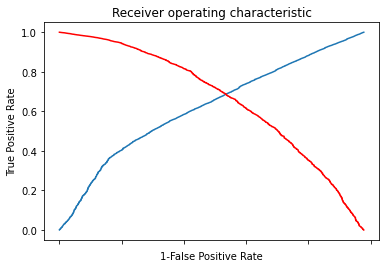

In [39]:
tpr = tpr_test
fpr = fpr_test

thresholds = thresholds_test
get_optimal_cutoff(tpr, fpr, thresholds)

In [40]:
threshold = 0.5

y_pred_train = np.where(yhat_train > 0.276966, 1, 0)
y_pred_test = np.where(yhat_test> 0.276966, 1, 0)

print(classification_report(y_test, 
                            y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79      7613
           1       0.40      0.67      0.50      2162

    accuracy                           0.70      9775
   macro avg       0.64      0.69      0.64      9775
weighted avg       0.78      0.70      0.73      9775



## Model Validation: Cross Validation

In [41]:
#Defining Kfold
kfold = KFold(n_splits=4, shuffle=True, random_state=SEED).split(X_train_trans, y_train)

#Defining the model
lr = LogisticRegression(random_state=SEED, C=5, max_iter=1000) # try to change C

#Initialize empty list for the scores
scores = []

#Loop the kfold
for k, (train, test) in enumerate(kfold):
    lr.fit(X_train_trans.iloc[train], y_train.iloc[train])
    
    yhat = lr.predict_proba(X_train_trans.iloc[test])[:, 1]
    score = roc_auc_score(y_train.iloc[test], yhat)
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train.iloc[train]), score))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [13363  3741], Acc: 0.753
Fold:  2, Class dist.: [13385  3719], Acc: 0.768
Fold:  3, Class dist.: [13395  3710], Acc: 0.758
Fold:  4, Class dist.: [13437  3668], Acc: 0.798
CV accuracy: 0.770 +/- 0.018


In [42]:
#Defining Kfold
skfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED).split(X_train_trans, y_train)

#Defining the model
lr = LogisticRegression(random_state=SEED, max_iter=1000)

#Initialize empty list for the scores
scores = []

#Loop the kfold
for k, (train, test) in enumerate(skfold):
    lr.fit(X_train_trans.iloc[train], y_train.iloc[train])
    
    yhat = lr.predict_proba(X_train_trans.iloc[test])[:, 1]
    score = roc_auc_score(y_train.iloc[test], yhat)
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train.iloc[train]), score))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [13395  3709], Acc: 0.791
Fold:  2, Class dist.: [13395  3709], Acc: 0.757
Fold:  3, Class dist.: [13395  3710], Acc: 0.760
Fold:  4, Class dist.: [13395  3710], Acc: 0.758
CV accuracy: 0.766 +/- 0.014


## Hyperparameter Tuning

### Simple Hyperparameter Tuning - GridSearchCV

In [43]:
lr = LogisticRegression(random_state=SEED)

param_space = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "max_iter": [1000],
    "random_state": [SEED]
}

clf = GridSearchCV(lr, 
                   param_space, 
                   scoring='roc_auc', 
                   cv=4, 
                   refit=True)

In [44]:
clf.fit(X_train_trans, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [1000], 'random_state': [42]},
             scoring='roc_auc')

In [45]:
fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

ROC-AUC TRAIN 0.7619865204907287
ROC-AUC TEST 0.7601628525528354


# Pipeline

### Implement data preprocess to pipeline

In [46]:
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
    ('ohe', OneHotEncoder(drop="first"))
])

num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

preprocess.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']

In [47]:
ohe_columns = preprocess.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_columns)

final_features = []
final_features.extend(ohe_columns)
final_features.extend(num_columns)

In [48]:
X_train_trans = pd.DataFrame(preprocess.transform(X_train), columns=final_features)
X_test_trans = pd.DataFrame(preprocess.transform(X_test), columns=final_features)

In [49]:
lr = LogisticRegression(random_state=SEED, max_iter=1000)
lr.fit(X_train_trans, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [50]:
yhat_train = lr.predict_proba(X_train_trans)[:, 1]
yhat_test = lr.predict_proba(X_test_trans)[:, 1]

In [51]:
fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

ROC-AUC TRAIN 0.8690962507058313
ROC-AUC TEST 0.8721478900750737


### Full Pipeline

In [52]:
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
    ('ohe', OneHotEncoder(drop="first"))
])

num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')


full_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(random_state=SEED, max_iter=1000))
])

In [53]:
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                      

In [54]:
yhat_train = full_pipe.predict_proba(X_train)[:, 1]
yhat_test = full_pipe.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

ROC-AUC TRAIN 0.8690962507058313
ROC-AUC TEST 0.8721478900750737


### Hyperparameter Tuning with Pipeline - GridSearchCV

In [55]:
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
    ('ohe', OneHotEncoder(drop="first"))
])

num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')


full_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(random_state=SEED, max_iter=1000))
])

In [56]:
param_space = {
    "model__C": [0.0001, 0.001, 0.01, 0.1, 2, 1, 3, 4, 5, 10, 100, 1000],
    "model__max_iter": [1000],
    "model__random_state": [SEED]
}

clf = GridSearchCV(full_pipe, 
                   param_space, 
                   scoring='roc_auc', 
                   cv=5, 
                   refit=True)

In [57]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
   

In [58]:
clf.best_params_

{'model__C': 3, 'model__max_iter': 1000, 'model__random_state': 42}

In [59]:
clf.best_estimator_.named_steps['model']

LogisticRegression(C=3, max_iter=1000, random_state=42)

In [60]:
yhat_train = clf.predict_proba(X_train)[:, 1]
yhat_test = clf.predict_proba(X_test)[:, 1]

In [61]:
fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

ROC-AUC TRAIN 0.8691484380695612
ROC-AUC TEST 0.8720164143008217


           fpr       tpr     1-fpr        tf  thresholds
1156  0.205175  0.796022  0.794825  0.001198    0.197456


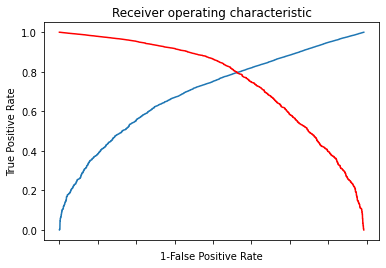

In [62]:
tpr = tpr_test
fpr = fpr_test

thresholds = thresholds_test
get_optimal_cutoff(tpr, fpr, thresholds)

In [ ]:
threshold = 0.5

y_pred_train = np.where(yhat_train > threshold, 1, 0)
y_pred_test = np.where(yhat_test> threshold, 1, 0)

print(classification_report(y_test, 
                            y_pred_test))

In [63]:
threshold = 0.4

y_pred_train = np.where(yhat_train > threshold, 1, 0)
y_pred_test = np.where(yhat_test> threshold, 1, 0)

print(classification_report(y_test, 
                            y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7613
           1       0.71      0.64      0.68      2162

    accuracy                           0.86      9775
   macro avg       0.81      0.79      0.80      9775
weighted avg       0.86      0.86      0.86      9775



In [64]:
X_train.loc[:, 'risk'] = y_train
X_train.loc[:, 'score_proba'] = yhat_train
X_test.loc[:, 'risk'] = y_test
X_test.loc[:, 'score_proba'] = yhat_test

In [65]:
X_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,risk,score_proba
14668,24,28000,OWN,6.0,HOMEIMPROVEMENT,B,10000,10.37,0.36,N,2,0,0.209736
24614,27,64000,RENT,0.0,PERSONAL,C,10000,15.27,0.16,Y,10,0,0.190602
11096,26,72000,MORTGAGE,10.0,EDUCATION,D,16000,15.36,0.22,N,3,0,0.408570
10424,23,27996,RENT,7.0,DEBTCONSOLIDATION,A,10000,7.33,0.36,N,2,1,0.682999
26007,30,44500,RENT,2.0,MEDICAL,E,13000,16.32,0.29,N,6,1,0.930121


## Save Your Model

In [66]:
import pickle 

MODELNAME = 'M-LR-1.0.0.pkl'
PREPROCESSNAME = 'FE-SC-IMP-OHE-1.0.0.pkl'

final_model = clf.best_estimator_.named_steps['model']
final_pipe = clf.best_estimator_.named_steps['preprocess']

with open(MODELNAME, 'wb') as f: # save model
    pickle.dump(final_model, f)
    
with open(PREPROCESSNAME, 'wb') as f: # save pipeline
    pickle.dump(final_pipe, f)

In [67]:
X_train.to_csv('train.csv')
X_test.to_csv('test.csv')

In [68]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__max_iter,param_model__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.093501,0.008089,0.020936,0.001697,0.0001,1000,42,"{'model__C': 0.0001, 'model__max_iter': 1000, ...",0.830564,0.833862,0.833816,0.834564,0.828470,0.832255,0.002347,12
1,0.111405,0.012699,0.026419,0.006118,0.001,1000,42,"{'model__C': 0.001, 'model__max_iter': 1000, '...",0.854206,0.853193,0.855478,0.854292,0.848556,0.853145,0.002406,11
2,0.135105,0.012596,0.022549,0.001192,0.01,1000,42,"{'model__C': 0.01, 'model__max_iter': 1000, 'm...",0.867986,0.865728,0.865960,0.866292,0.860773,0.865348,0.002421,10
3,0.195850,0.023581,0.022427,0.002218,0.1,1000,42,"{'model__C': 0.1, 'model__max_iter': 1000, 'mo...",0.869583,0.867102,0.867801,0.867990,0.864344,0.867364,0.001714,9
4,0.278699,0.025944,0.022339,0.003320,2,1000,42,"{'model__C': 2, 'model__max_iter': 1000, 'mode...",0.870392,0.866610,0.868660,0.868939,0.866295,0.868179,0.001531,4
5,0.253670,0.008653,0.021563,0.003172,1,1000,42,"{'model__C': 1, 'model__max_iter': 1000, 'mode...",0.870302,0.866815,0.868640,0.868859,0.866082,0.868140,0.001512,8
6,0.271331,0.022372,0.020683,0.001862,3,1000,42,"{'model__C': 3, 'model__max_iter': 1000, 'mode...",0.870420,0.866531,0.868662,0.868956,0.866384,0.868191,0.001536,1
7,0.332039,0.054050,0.029183,0.009143,4,1000,42,"{'model__C': 4, 'model__max_iter': 1000, 'mode...",0.870440,0.866453,0.868652,0.868947,0.866423,0.868183,0.001548,3
8,0.279134,0.012386,0.021096,0.002966,5,1000,42,"{'model__C': 5, 'model__max_iter': 1000, 'mode...",0.870459,0.866423,0.868642,0.868966,0.866441,0.868186,0.001558,2
9,0.306830,0.038157,0.024754,0.005142,10,1000,42,"{'model__C': 10, 'model__max_iter': 1000, 'mod...",0.870486,0.866357,0.868625,0.868976,0.866445,0.868178,0.001580,5


In [70]:
X_train.sample(1).to_dict(orient='records')

[{'person_age': 26,
  'person_income': 70000,
  'person_home_ownership': 'RENT',
  'person_emp_length': 2.0,
  'loan_intent': 'DEBTCONSOLIDATION',
  'loan_grade': 'B',
  'loan_amnt': 10000,
  'loan_int_rate': 9.45,
  'loan_percent_income': 0.14,
  'cb_person_default_on_file': 'N',
  'cb_person_cred_hist_length': 3,
  'risk': 0,
  'score_proba': 0.14392983630375794}]